# ** DIscBIO: a user-friendly pipeline for biomarker discovery in single-cell transcriptomics**

The pipeline consists of four successive steps: data pre-processing, cellular clustering and pseudo-temporal ordering, determining differential expressed genes and identifying biomarkers.

![DIsccBIO](DiscBIO.png)

#                      CTC Notebook  [PART 3]

#  Determining differentially expressed genes and  biomarkers

## Required Packages

In [1]:
library(DIscBIO)
library(partykit)
library(enrichR)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

## 3. Determining differentially expressed genes (DEGs) For K-means Clustering

Differentially expressed genes between individual clusters are identified using the significance analysis of sequencing data (SAMseq), which is a new function in significance analysis of microarrays (Li and Tibshirani 2011) in the samr package v2.0 (Tibshirani et all., 2015). SAMseq is a non-parametric statistical function dependent on Wilcoxon rank statistic that equalizes the sizes of the library by a resampling method accounting for the various sequencing depths. The analysis is implemented over the pure raw dataset that has the unnormalized expression read counts after excluding the ERCCs. Furthermore, DEGs in each cluster comparing to all the remaining clusters are determined using binomial differential expression, which is based on binomial counting statistics.

![DIsccBIO](KM2.png)

## 3.1 Identifying DEGs using SAMseq

The user can define DEGs between all clusters generated by either K-means or model based clustering by applying the “DEGanalysis” function. Another alternative is to define DEGs between particular clusters generated by K-means clustering by applying the “DEGanalysis2clust” function. The outcome of these two functions is a list of two components:
- The first component is a data frame showing the Ensembl gage name and the symbole of the detected DEGs
- The second component is table showing the comparisons, Target cluster, Number of genes and the File name. This component will be used for the downstream analysis.

In [2]:
load("SC.RData")           # Loading the "SC" object that has include the data of the k-means clustering 
load("Ndata.RData")        # Loading the "Ndata" object and stored in the @ndata will be used to plot the expression of genes 
load("expdata.RData")      # Loading the "expdata" object and stored in the @expdata will be used to plot the expression of genes 
sc<-SC                     # Storing the data of SC in the sc 
sc@ndata<-Ndata
sc@expdata<-expdata

########## Removing the unneeded objects
rm(Ndata)
rm(expdata)
rm(SC)  

## Identifying DEGs using binomial differential expression

The function ClustDiffGenes identifies differentially regulated genes for each cluster of the K-means clustering in 
comparison to the ensemble of all cells. It returns a list with a data.frame element for each cluster that contains the mean expression across all cells not in the cluster (mean.ncl) and in the cluster (mean.cl), the fold-change in the cluster versus all remaining cells (fc), and the p-value for differential expression between all cells in a cluster and all remaining cells. The p-value is computed based on the overlap of negative binomials fitted to the count distributions within the two groups akin to DESeq.

In [3]:
cdiffBinomial<-ClustDiffGenes(sc,K=4,export = T,fdr=.01,quiet=T)    ########## Binomial differential expression analysis
#### To show the result table
head(cdiffBinomial[[1]])                  # The first component 
head(cdiffBinomial[[2]])                  # The second component

DEGsE,DEGsS
ENSG00000001630,CYP51A1
ENSG00000002586,CD99
ENSG00000003402,CFLAR
ENSG00000003436,TFPI
ENSG00000003756,RBM5
ENSG00000004059,ARF5


,Target Cluster,VS,Gene number,File name,Gene number,File name
,<chr>,<chr>,<int>,<chr>,<int>,<chr>
1,Cluster 1,Remaining Clusters,1052,Up-DEG-cluster1.csv,678,Down-DEG-cluster1.csv
2,Cluster 2,Remaining Clusters,0,Up-DEG-cluster2.csv,1,Down-DEG-cluster2.csv
3,Cluster 3,Remaining Clusters,2,Up-DEG-cluster3.csv,5,Down-DEG-cluster3.csv
4,Cluster 4,Remaining Clusters,1,Up-DEG-cluster4.csv,1,Down-DEG-cluster4.csv


### Plotting the DEGs

Volcano plots are used to readily show the DEGs by plotting significance versus fold-change on the y and x axes, respectively.

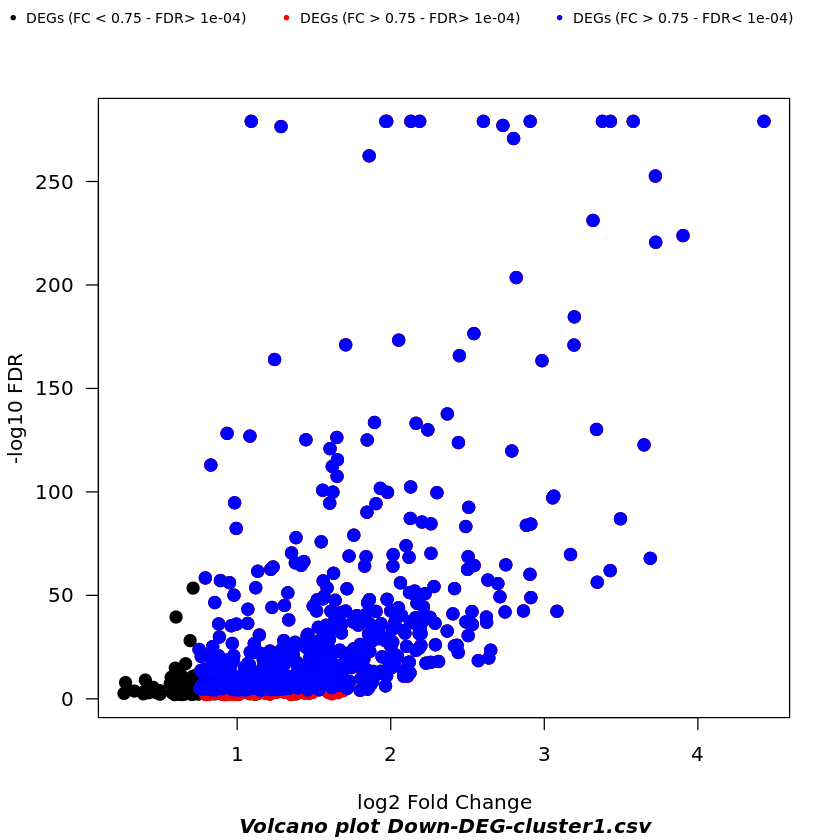

In [4]:
name<-cdiffBinomial[[2]][1,6]    ############ Selecting the DEGs' ############## Down-DEG-cluster1.csv
U<-read.csv(file=paste0(name),head=TRUE,sep=",")
Vplot<-VolcanoPlot(U,value=0.0001,name=name,FS=0.7,fc=0.75)

## 4. Identifying biomarkers (decision trees and networking analysis) 

There are several methods to identify biomarkers, among them are decision trees and hub detection through networking analysis. The outcome of STRING analysis is stored in tab separated values (TSV) files. These TSV files served as an input to check both the connectivity degree and the betweenness centrality, which reflects the communication flow in the defined PPI networks 

![DIsccBIO](KM3.png)

Decision trees are one of the most efficient classification techniques in biomarkers discovery. Here we use it to predict the sub-population of a target cell based on transcriptomic data. Two types of decision trees can be performed: classification and regression trees (CART) and J48. The decision tree analysis is implemented over a training dataset, which consisted of the DEGs obtained by either SAMseq or the binomial differential expression. The performance of the generated trees can be evaluated for error estimation by ten-fold cross validation assessment using the "J48DTeval" and "RpartEVAL" functions. The decision tree analysis requires the dataset to be class vectored by applying the “ClassVectoringDT” function.

In [5]:
###################### Finding biomarker genes between cluster 1 and cluster 4
First="CL1"
Second="CL4"
load("DATAforDT.RData")

### 4.1. J48 Decision Tree

J48 pruned tree
------------------

MALAT1 <= 102.794044: CL1 (344.0/1.0)
MALAT1 > 102.794044
|   CA1 <= 0.103233: CL4 (693.0)
|   CA1 > 0.103233
|   |   SLC25A39 <= 6.310579: CL4 (17.0)
|   |   SLC25A39 > 6.310579: CL1 (8.0/1.0)

Number of Leaves  : 	4

Size of the tree : 	7




=== Summary ===

Correctly Classified Instances        1060               99.8117 %
Incorrectly Classified Instances         2                0.1883 %
Kappa statistic                          0.9957
Mean absolute error                      0.0035
Root mean squared error                  0.042 
Relative absolute error                  0.7976 %
Root relative squared error              8.9321 %
Total Number of Instances             1062     

=== Confusion Matrix ===

   a   b   <-- classified as
 350   0 |   a = CL1
   2 710 |   b = CL4

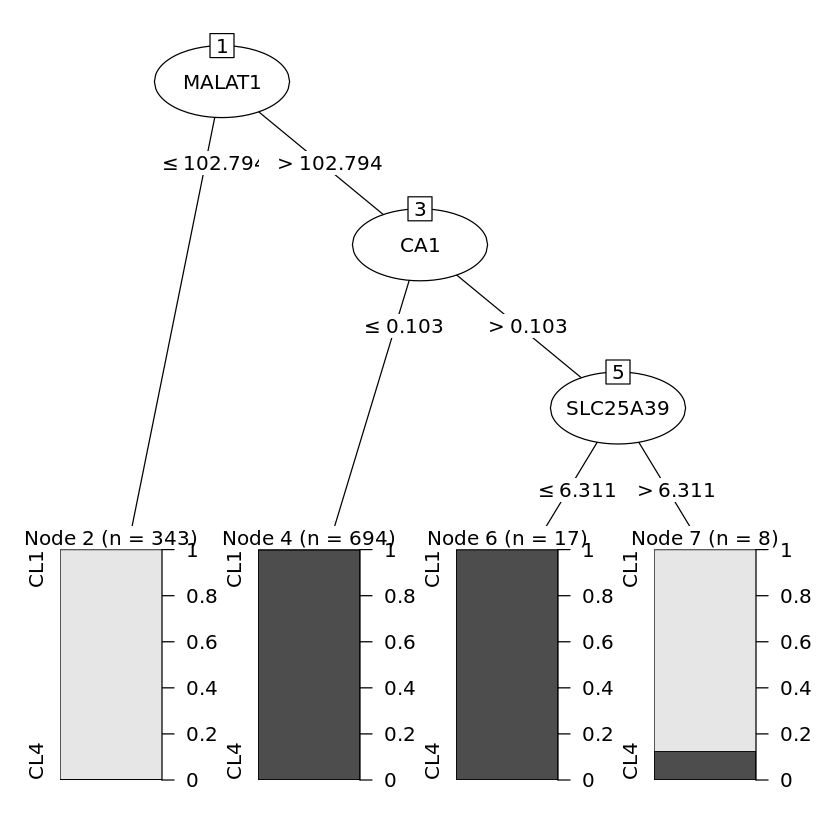

In [6]:
j48dt<-J48DT(DATAforDT)           #J48 Decision Tree
summary(j48dt) 
rm(j48dt)

### 4.2. RPART Decision Tree

n= 1062 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 1062 350 CL4 (0.329566855 0.670433145)  
   2) MALAT1< 104.7847 344   1 CL1 (0.997093023 0.002906977)  
     4) SYNE2< 12.34286 343   0 CL1 (1.000000000 0.000000000) *
     5) SYNE2>=12.34286 1   0 CL4 (0.000000000 1.000000000) *
   3) MALAT1>=104.7847 718   7 CL4 (0.009749304 0.990250696)  
     6) SLC25A39>=7.9044 8   1 CL1 (0.875000000 0.125000000)  
      12) CFLAR< 4.819648 7   0 CL1 (1.000000000 0.000000000) *
      13) CFLAR>=4.819648 1   0 CL4 (0.000000000 1.000000000) *
     7) SLC25A39< 7.9044 710   0 CL4 (0.000000000 1.000000000) *


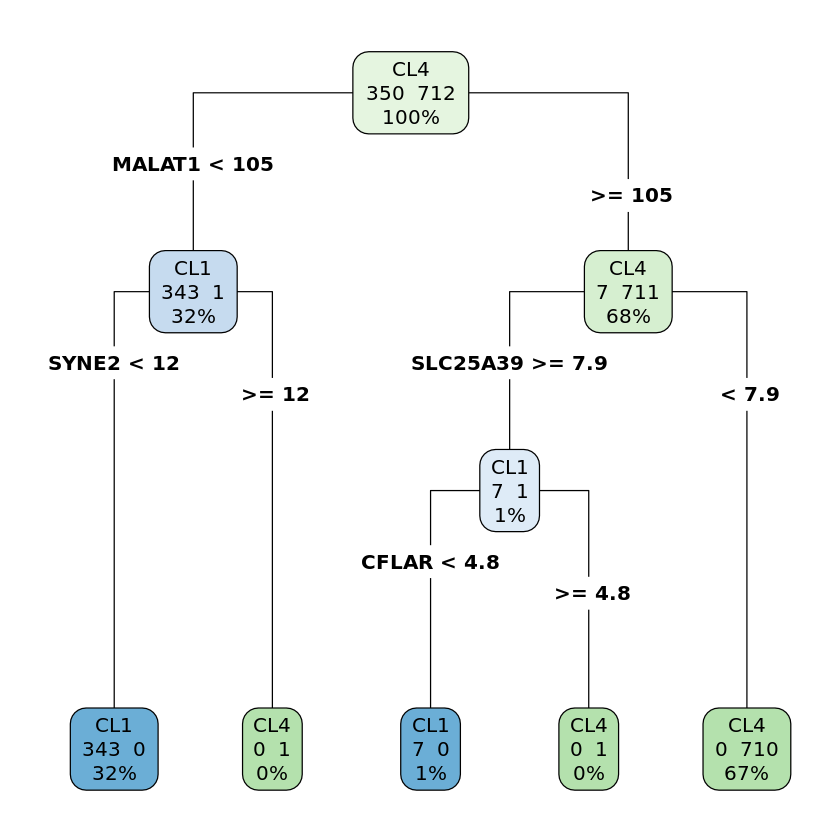

In [7]:
rpartDT<-RpartDT(DATAforDT)
rm(rpartDT)

### 4.3. Networking Analysis

To define protein-protein interactions (PPI) over a list of genes, STRING-api is used. The outcome of STRING analysis was stored in tab separated values (TSV) files. These TSV files served as an input to check both the connectivity degree and the betweenness centrality, which reflects the communication flow in the defined PPI networks.

In [8]:
DEGs="All_DEGs"
FileName=paste0(DEGs)

data<-cdiffBinomial[[1]] [1:200,2]       # DEGs gene list from Binomial analysis (taking only the firat 200 genes)

ppi<-PPI(data,FileName)

networking<-NetAnalysis(ppi)
networking                            ##### In case the Examine response components = 200 and an error "linkmat[i, ]" appeared, that means there are no PPI.

Retrieving URL. Please wait...

Successful retrieval.


── Column specification ────────────────────────────────────────────────────────
cols(
  stringId_A = col_character(),
  stringId_B = col_character(),
  preferredName_A = col_character(),
  preferredName_B = col_character(),
  ncbiTaxonId = col_double(),
  score = col_double(),
  nscore = col_double(),
  fscore = col_double(),
  pscore = col_double(),
  ascore = col_double(),
  escore = col_double(),
  dscore = col_double(),
  tscore = col_double()
)


Number of nodes: 174

Number of links: 451

Link Density: 2.59195402298851

The connectance of the graph: 0.0149823931964654

Mean Distences2.52208201892744

Average Path Length2.52208201892744




,names,degree,betweenness
,<chr>,<dbl>,<dbl>
74,HSP90AA1,29,818.84444
85,ACTB,24,389.53333
134,RHOA,22,0.00000
83,FYN,18,105.71667
125,CD44,16,55.25000
24,VCL,15,0.00000
31,ENO1,15,82.85556
79,CS,15,237.03889
127,RPS20,15,26.20000


Retrieving URL. Please wait...

Successful retrieval.


You can see the network with high resolution by clicking on the following link:
https://string-db.org/api/highres_image/network?identifiers=HSP90AA1%0dACTB%0dRHOA%0dFYN%0dCD44%0dVCL%0dENO1%0dCS%0dRPS20%0dTNFRSF1A%0dHSPA5%0dTFRC%0dEIF3I%0dSDHA%0dACTN1%0dITGA2B%0dCTNNA1%0dNME1-NME2%0dMDH1%0dRPL18%0dCAPZB%0dRPS5%0dPSMA4%0dSLC11A1%0dRPL31&species=9606



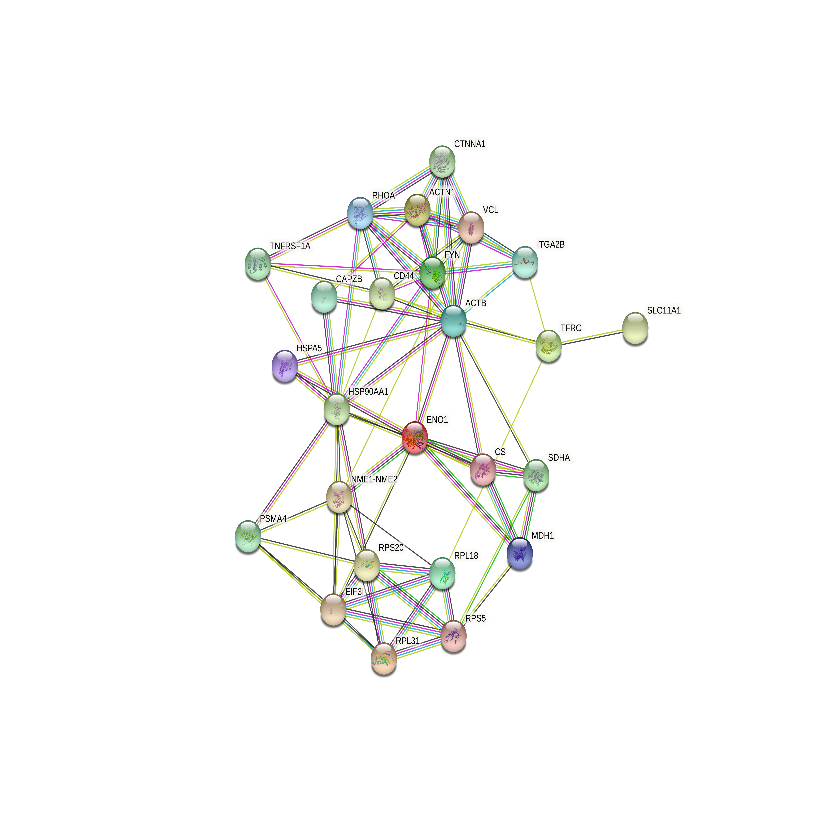

In [9]:
data=networking[1:25,1]              # plotting the network of the top 25 highly connected genes 
network<-Networking(data,FileName,plot_width = 25, plot_height = 10)


### 4.4 Gene Enrichment Analysis

In [10]:
dbs <- listEnrichrDbs()
head(dbs)
#print(dbs)

,geneCoverage,genesPerTerm,libraryName,link,numTerms
,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,13362,275,Genome_Browser_PWMs,http://hgdownload.cse.ucsc.edu/goldenPath/hg18/database/,615
2,27884,1284,TRANSFAC_and_JASPAR_PWMs,http://jaspar.genereg.net/html/DOWNLOAD/,326
3,6002,77,Transcription_Factor_PPIs,,290
4,47172,1370,ChEA_2013,http://amp.pharm.mssm.edu/lib/cheadownload.jsp,353
5,47107,509,Drug_Perturbations_from_GEO_2014,http://www.ncbi.nlm.nih.gov/geo/,701
6,21493,3713,ENCODE_TF_ChIP-seq_2014,http://genome.ucsc.edu/ENCODE/downloads.html,498


In [11]:
############ Selecting the DEGs' table  ##############
DEGs=cdiffBinomial[[2]][1,4]             # Down-regulated markers in cluster 1 
FileName=paste0(DEGs)

data<-read.csv(file=paste0(DEGs),head=TRUE,sep=",")
data<-as.character(data[,3])

dbs <- c("KEGG_2019_Human","GO_Biological_Process_2015")
enriched <- enrichr(data, dbs)
KEGG_2019_Human<-enriched[[1]][,c(1,2,3,9)]
GO_Biological_Process_2015<-enriched[[2]][,c(1,2,3,9)]

GEA<-rbind(KEGG_2019_Human,GO_Biological_Process_2015)
GEA

Uploading data to Enrichr... Done.
  Querying KEGG_2019_Human... Done.
  Querying GO_Biological_Process_2015... Done.
Parsing results... Done.


Term,Overlap,P.value,Genes
<chr>,<chr>,<dbl>,<chr>
Ribosome,66/153,1.195049e-43,RPL4;RPL5;RPL30;MRPS15;RPL3;RPL32;RPL31;MRPS11;RPLP1;MRPS12;RPLP0;RPL10A;RPL6;RPL7;RPS4X;RPS14;MRPL3;RPS16;RPL18A;RPL36;RPL35;MRPL9;RPS11;RPS13;RPL21;RPS7;RPS8;RPS5;RPS6;MRPS18A;RPL13A;MRPS21;RPSA;RPS3A;MRPS7;RPL37A;RPL24;RPL27;RPL26;RPL29;UBA52;RPL12;RPL11;MRPL14;MRPL15;MRPL12;MRPL13;MRPL11;RPL14;RPS3;RPL15;RPS2;RPL18;RPS27A;RPL17;RPL19;RPL41;RPL35A;RPL23A;RPS27;RPS20;RPL22L1;FAU;RPS21;RPS24;RPS23
Proteasome,25/45,9.261661e-21,PSMD14;PSMA7;PSMD8;PSMB6;PSMB7;PSMB4;PSMB5;PSMB2;PSMB3;PSMD2;PSMB1;PSMD3;PSMD1;PSMF1;ADRM1;PSMA5;PSMA6;PSMC5;PSMA3;PSMA4;PSMC3;PSMC4;PSME3;PSMC2;PSME1
Protein processing in endoplasmic reticulum,36/165,2.122271e-13,VCP;HSP90AB1;RPN2;RPN1;DERL1;HERPUD1;SEC61A1;GANAB;LMAN2;BAG1;CAPN2;UBQLN1;SEC61B;SKP1;TXNDC5;SEC31A;PDIA3;HSPA8;XBP1;SEC13;HSP90AA1;HSPA5;WFS1;SSR2;SSR3;RAD23A;HSPA2;PDIA6;EIF2S1;CKAP4;DDOST;PDIA4;DNAJA1;CANX;CALR;P4HB
Huntington disease,37/193,6.230550e-12,NDUFB9;DNAH1;NDUFA11;NDUFB6;DCTN2;DCTN1;COX7A2;COX5B;COX5A;POLR2A;UQCRFS1;CYC1;POLR2H;NDUFV2;NDUFV1;AP2M1;POLR2K;TGM2;COX8A;NDUFA9;NDUFC2;COX6C;SDHA;COX6B1;SOD1;CREB3;NDUFS7;NDUFAB1;UQCRC1;NDUFS3;CYCS;NDUFS2;VDAC1;UQCRC2;SLC25A5;SLC25A4;SLC25A6
Cell cycle,27/124,2.241324e-10,PCNA;MCM7;PRKDC;YWHAB;PKMYT1;ANAPC11;CDC20;CCNB2;CCNB1;CCND1;PTTG1;YWHAQ;MYC;BUB3;SKP1;ANAPC7;PLK1;CDC25B;CCNA2;TFDP1;CCNE2;CDK4;CDK1;MCM3;MCM4;MCM5;MCM2
Oxidative phosphorylation,28/133,2.399141e-10,NDUFB9;NDUFA11;NDUFB6;COX7A2;COX5B;COX5A;UQCRFS1;CYC1;NDUFV2;NDUFV1;ATP6V1C2;COX8A;NDUFA9;ATP6V1G1;ATP6V0B;NDUFC2;SDHA;COX6C;COX6B1;PPA2;NDUFS7;PPA1;NDUFAB1;UQCRC1;NDUFS3;NDUFS2;UQCRC2;ATP6V0C
Parkinson disease,29/142,2.477250e-10,NDUFB9;NDUFA11;NDUFB6;UBE2L6;COX7A2;COX5B;COX5A;UBB;UQCRFS1;CYC1;NDUFV2;NDUFV1;COX8A;NDUFA9;NDUFC2;SDHA;COX6C;COX6B1;NDUFS7;NDUFAB1;UQCRC1;NDUFS3;CYCS;NDUFS2;VDAC1;UQCRC2;SLC25A5;SLC25A4;SLC25A6
Protein export,12/23,3.326536e-10,OXA1L;SEC61A1;SPCS1;HSPA5;SRP72;SRP54;SRPRB;SRP68;SEC61B;SRP14;SEC11A;SRP9
Alzheimer disease,30/171,5.527120e-09,NDUFB9;NDUFA11;NDUFB6;COX7A2;ITPR3;COX5B;COX5A;NCSTN;CAPN2;UQCRFS1;CYC1;NDUFV2;NDUFV1;COX8A;PSENEN;NDUFA9;NDUFC2;SDHA;COX6C;COX6B1;TNFRSF1A;NDUFS7;NDUFAB1;UQCRC1;NDUFS3;CYCS;NDUFS2;UQCRC2;CALM2;GAPDH
